In [1]:
import pandas as pd
import numpy as np
from copy import copy
import torch
import matplotlib.pyplot as plt

In [2]:
dataset_path = 'training_data_1718.csv'

In [3]:
def file_to_data(filename):
    
    # read file
    raw = pd.read_csv(filename)
    
    # define columns to be extracted
    ndvi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., ndvi_mean24
    savi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., savi_mean24
    evi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., evi_mean24

    # extract each feature
    ndvi_timeseries = raw[ndvi_col]
    savi_timeseries = raw[savi_col]
    evi_timeseries = raw[evi_col]
    
    # dimension stack
    data = np.dstack([ndvi_timeseries, savi_timeseries, evi_timeseries])
    
    # get only label
    label = raw.iloc[:, -1]
    
    return data, label

def data_to_lv1_x_y(data, labels):
    
    # export all X
    # but reclass the plant cane -> 100, ratoon cane -> 200
    target = copy(labels)
    target[target > 200] = 200
    target[(target < 200) & (target > 100)] = 100
    
    return data, target

def data_to_lv2_x_y(data, target):
    
    # export X plant which labels are 100-200
    X_plant = data[(target > 100) & (target <200)]
    
    # export X ratoon which labels are >200
    X_ratoon = data[target > 200]
    
    # export y plant which labels are 100-200
    y_plant = target[(target > 100) & (target < 200)]
    
    # export y ratoon which labels are >200
    y_ratoon = target[target > 200]
    
    return X_plant, y_plant, X_ratoon, y_ratoon

def label_encode(y):
    
    target = copy(y)
    # redefine the cane plantation label to be 1 - 24
    new_y = [int(str(label)[1:]) for label in target]
    
    return np.array(new_y)

In [4]:
data_train, labels_train = file_to_data('training_data_1718.csv')
data_test, labels_test = file_to_data('training_data_1819.csv')

In [5]:
X_train, y_train = data_to_lv1_x_y(data_train, labels_train)
X_test, y_test = data_to_lv1_x_y(data_test, labels_test)

In [6]:
from sklearn.preprocessing import LabelEncoder

lu_encoder = LabelEncoder()

y_train = lu_encoder.fit_transform(y_train)
y_test = lu_encoder.transform(y_test)

In [7]:
print(f'numeric class of y train: {np.unique(y_train)}')
print(f'numeric class of y test: {np.unique(y_test)}')

numeric class of y train: [ 0  1  2  3  4  5  6  7  8  9 10 11]
numeric class of y test: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [8]:
y_train[y_train>9] = 10
y_test[y_test > 9] = 10

In [9]:
print(f'numeric class of y train: {np.unique(y_train)}')
print(f'numeric class of y test: {np.unique(y_test)}')

numeric class of y train: [ 0  1  2  3  4  5  6  7  8  9 10]
numeric class of y test: [ 0  1  2  3  4  5  6  7  8  9 10]


In [10]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [11]:
shape = X_train.shape
print(Counter(y_train))

Counter({10: 12367, 0: 118, 1: 92, 2: 85, 4: 30, 5: 30, 7: 30, 9: 30, 8: 30, 3: 26, 6: 22})


In [12]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_train.shape

(12860, 72)

In [13]:
# instantiating the random over sampler 
ros = RandomOverSampler()
# resampling X, y
X_train, y_train = ros.fit_resample(X_train, y_train)

print(f'after oversampled-> X shape: {X_train.shape}')

after oversampled-> X shape: (136037, 72)


In [14]:
X_train = X_train.reshape(X_train.shape[0], 24,3)
X_train.shape

(136037, 24, 3)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train  , test_size=0.3)

In [16]:
X_train_ndvi = X_train[:,0,:]
X_valid_ndvi = X_valid[:,0,:]
X_train_savi = X_train[:,1,:]
X_valid_savi = X_valid[:,1,:]
X_train_evi = X_train[:,2,:]
X_valid_evi = X_valid[:,2,:]

In [17]:
#this is the same as RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier()

model.fit(X_train_ndvi, y_train)

yhat = model.predict(X_valid_ndvi)

print(classification_report(y_valid, yhat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3764
           1       0.99      1.00      1.00      3598
           2       0.99      1.00      1.00      3748
           3       1.00      1.00      1.00      3708
           4       1.00      1.00      1.00      3763
           5       1.00      1.00      1.00      3708
           6       1.00      1.00      1.00      3696
           7       1.00      1.00      1.00      3727
           8       1.00      1.00      1.00      3693
           9       1.00      1.00      1.00      3700
          10       1.00      0.96      0.98      3707

    accuracy                           1.00     40812
   macro avg       1.00      1.00      1.00     40812
weighted avg       1.00      1.00      1.00     40812



In [18]:
model = RandomForestClassifier()
model.fit(X_train_savi, y_train)
yhat = model.predict(X_valid_savi)
print(classification_report(y_valid, yhat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3764
           1       0.99      1.00      1.00      3598
           2       1.00      1.00      1.00      3748
           3       1.00      1.00      1.00      3708
           4       1.00      1.00      1.00      3763
           5       1.00      1.00      1.00      3708
           6       1.00      1.00      1.00      3696
           7       1.00      1.00      1.00      3727
           8       1.00      1.00      1.00      3693
           9       1.00      1.00      1.00      3700
          10       1.00      0.97      0.98      3707

    accuracy                           1.00     40812
   macro avg       1.00      1.00      1.00     40812
weighted avg       1.00      1.00      1.00     40812



In [19]:
model = RandomForestClassifier()
model.fit(X_train_evi, y_train)
yhat = model.predict(X_valid_evi)
print(classification_report(y_valid, yhat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3764
           1       0.99      1.00      1.00      3598
           2       1.00      1.00      1.00      3748
           3       1.00      1.00      1.00      3708
           4       1.00      1.00      1.00      3763
           5       0.99      1.00      1.00      3708
           6       1.00      1.00      1.00      3696
           7       1.00      1.00      1.00      3727
           8       1.00      1.00      1.00      3693
           9       1.00      1.00      1.00      3700
          10       1.00      0.97      0.99      3707

    accuracy                           1.00     40812
   macro avg       1.00      1.00      1.00     40812
weighted avg       1.00      1.00      1.00     40812



In [20]:
X_test = X_test.reshape(X_test.shape[0], 24,3)
X_test_ndvi = X_test[:,0,:]

In [21]:
y_preds = model.predict(X_test_ndvi)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       118
           1       0.72      0.28      0.41        92
           2       0.18      0.56      0.27        85
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        30
           5       0.10      0.07      0.08        30
           6       0.00      0.00      0.00        22
           7       0.01      0.03      0.01        30
           8       0.00      0.00      0.00        30
           9       0.00      0.00      0.00        30
          10       0.97      0.93      0.95      7452

    accuracy                           0.90      7945
   macro avg       0.27      0.26      0.25      7945
weighted avg       0.93      0.90      0.91      7945



Text(33.0, 0.5, 'predicted')

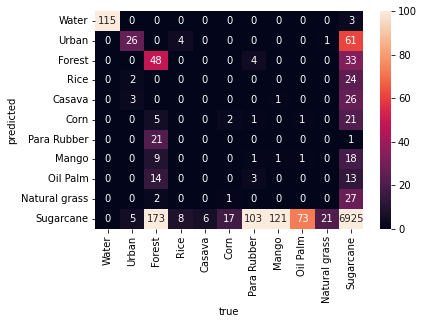

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix_plant = confusion_matrix(y_test, y_preds)
xticklabels = ["Water", "Urban", "Forest", "Rice", "Casava", "Corn", "Para Rubber", "Mango", "Oil Palm", "Natural grass", "Sugarcane"]
yticklabels = ["Water", "Urban", "Forest", "Rice", "Casava", "Corn", "Para Rubber", "Mango", "Oil Palm", "Natural grass", "Sugarcane"]

sns.heatmap(cf_matrix_plant, fmt="d",vmax=100 ,annot=True,xticklabels=xticklabels, yticklabels=yticklabels)
plt.xlabel('true')
plt.ylabel('predicted')